# SHAPE nucleotide reactivity value prediction using Feedforward Neural Network
---



## Requirements:
- Python 3
- Dictionaries & Lists
- Numpy
- Pandas
- Pytorch

## Software Used:
-	Google Colab or Jupyter Notebook


### Importing Relevant Libraries


---


Note: 
- If You do no have them installed, Run **!pip install "Library Name here"**. For Example, if I want to install **numpy**, I will write !pip install numpy


In [2]:
import numpy as np
import pandas as pd
import random
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import GridSearchCV


### Creating Training Data: 
We will transform the data into a format that our PyTorch Model can Easily Understand


20 x : 1 y

In [3]:
# Sliding window with window size 21, the middle value as target value y, the other 20 values as x
# xxxxxxxxxxyxxxxxxxxxx

X = []
y = []
window_size = 21

def sliding_window_extraction(df):
    global c
    length = df.shape[0]
    for index in range(length-20):
        x_i = []
        for k in range(index, index+window_size):
            x_i.append(df['reactivity'][k])
        # remove the 11th element y from 21 elements
        x_i.pop(10)
        if not np.all(x_i == x_i[0]):    
            X.append(x_i)
            y.append(df['reactivity'][index+10])

In [6]:
# return the percentage of invalid data in one file
def percentage_invalid(df):
    return len(df[df['reactivity']==-5])/len(df)

In [4]:
#clean the dataframe such that there is no invalid data at the top or bottom
def clean_df(df):
    # from top to bottom
    top=0
    i=0
    j=len(df)-1
    while top==0:
        if df['reactivity'][i] == -5:
            df = df.drop([i])
            i=i+1
        else:
            top = 1
            
    # from bottom to the top
    bottom=0
    while bottom==0:
        if df['reactivity'][j] == -5:
            df = df.drop([j])
            j=j-1
        else:
            bottom = 1
            
    return df

In [7]:
# Read the data file from the folder

entries = os.scandir(r'./shape')
invalid_set = ""
weird_set = ""
percentage_set = []
for entry in entries:
    df = pd.read_csv(entry, delimiter = "\t", header=None, names=["index", "reactivity"])
    df['reactivity'] = df['reactivity'].replace(-999,-5)
    if np.all(df['reactivity'] == df['reactivity'][0]):
        invalid_set = invalid_set+str(entry)+"  "
    else:
        df = clean_df(df).reset_index(drop=True)
        sliding_window_extraction(df)
        if percentage_invalid(df)>0.08:
            percentage_set.append(percentage_invalid(df))
            weird_set = weird_set+str(entry)+"  "

In [41]:
# Read the data file from the folder

entries = os.scandir(r'./shape')
invalid_set = ""
weird_set = ""
percentage_set = []
for entry in entries:
    df = pd.read_csv(entry, delimiter = "\t", header=None, names=["index", "reactivity"])
    df['reactivity'] = df['reactivity'].replace(-999,-5)
    if np.all(df['reactivity'] == df['reactivity'][0]):
        invalid_set = invalid_set+str(entry)+"  "
    else:
        sliding_window_extraction(df)
        if percentage_invalid(df)>0.3:
            percentage_set.append(percentage_invalid(df))
            weird_set = weird_set+str(entry)+"  "

In [12]:
# the percentage of invalid data in one file

print(percentage_set)
print(weird_set)

[0.13513513513513514, 0.3744493392070485, 0.08108108108108109, 0.09696969696969697]
<DirEntry 'Pipeline_4V7B_23.shape'>  <DirEntry 'Pipeline_6Q98_57.shape'>  <DirEntry 'Pipeline_6SVS_1.shape'>  <DirEntry 'Pipeline_6WLN_1.shape'>  


In [13]:
# the percentage of invalid data in one file

print(percentage_set)
print(weird_set)

[0.13513513513513514, 0.3744493392070485, 0.08108108108108109, 0.09696969696969697]
<DirEntry 'Pipeline_4V7B_23.shape'>  <DirEntry 'Pipeline_6Q98_57.shape'>  <DirEntry 'Pipeline_6SVS_1.shape'>  <DirEntry 'Pipeline_6WLN_1.shape'>  


In [14]:
invalid_set

"<DirEntry 'Pipeline_1LNG_1.shape'>  <DirEntry 'Pipeline_2GTT_2.shape'>  <DirEntry 'Pipeline_3IYQ_1.shape'>  <DirEntry 'Pipeline_3Q1Q_1.shape'>  <DirEntry 'Pipeline_4E8M_1.shape'>  <DirEntry 'Pipeline_4V5Z_32.shape'>  <DirEntry 'Pipeline_5ZEY_1.shape'>  <DirEntry 'Pipeline_6AGB_1.shape'>  <DirEntry 'Pipeline_6AHU_1.shape'>  <DirEntry 'Pipeline_6T3K_1.shape'>  <DirEntry 'Pipeline_6ZJ3_42.shape'>  "

In [15]:
# Dimensions of the data
print(len(X))
print(len(y))
print("x: ", X[1])
print("X size:", len(X[1]))
print("y: ", (y[1]))

20547
20547
x:  [0.174412, 0.028481, 0.26327, 0.238318, 1.543775, 0.334246, 0.081736, 0.267372, 2.423364, 1.124189, 2.946678, 0.856317, 0.340136, 0.089146, 0.083207, 1.431363, 0.303295, 0.454896, 0.238207, 2.491291]
X size: 20
y:  0.151453


In [10]:
# create training data
X_train = []
y_train = []

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=train_size)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(16437, 20)
(16437,)
(2055, 20)
(2055,)
(2055, 20)
(2055,)


(None, None)

In [16]:
np.savetxt('./data/X_train_-999to-5_removal.txt',X_train)
np.savetxt('./data/y_train_-999to-5_removal.txt',y_train)
np.savetxt('./data/X_valid_-999to-5_removal.txt',X_valid)
np.savetxt('./data/y_valid_-999to-5_removal.txt',y_valid)
np.savetxt('./data/X_test_-999to-5_removal.txt',X_test)
np.savetxt('./data/y_test_-999to-5_removal.txt',y_test)

# Starting from here for the splited train validation and test dataset

In [9]:
X_train = np.loadtxt("./data/X_train_-999to-5_removal.txt")
y_train = np.loadtxt("./data/y_train_-999to-5_removal.txt")
X_valid = np.loadtxt("./data/X_valid_-999to-5_removal.txt")
y_valid = np.loadtxt("./data/y_valid_-999to-5_removal.txt")
X_test = np.loadtxt("./data/X_test_-999to-5_removal.txt")
y_test = np.loadtxt("./data/y_test_-999to-5_removal.txt")

In [3]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(203113, 20)
(203113,)
(25389, 20)
(25389,)
(25390, 20)
(25390,)


(None, None)


## PyTorch Model
---
Here we will be making a class to implement our custom neural network. It will be a feed forward neural Network which will have 3 Linear Layers and we will be using activation function “ReLU” . 


### Feed Forward Neural Network

`A feedforward neural network is an artificial neural network wherein connections between the nodes do not form a cycle. As such, it is different from its descendant: recurrent neural networks.`


The feedforward neural network was the first and simplest type of artificial neural network devised In this network, the information moves in only one direction—forward—from the input nodes, through the hidden nodes (if any) and to the output nodes. There are no cycles or loops in the network [1] 




### ReLU Function:
There are a number of widely used activation functions in deep learning today. One of the simplest is the rectified linear unit, or ReLU function, which is a piece wise linear function that outputs zero if its input is negative, and directly outputs the input otherwise:


## Creating our Model
---

In [21]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, hidden_size_5, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size_1) 
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.l3 = nn.Linear(hidden_size_2, hidden_size_3) 
        self.l4 = nn.Linear(hidden_size_3, hidden_size_4) 
        self.l5 = nn.Linear(hidden_size_4, hidden_size_5) 
        self.l6 = nn.Linear(hidden_size_5, num_classes) 
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        out = self.relu(out)
        out = self.l6(out)
        
        return out


Here we have inherited a class from NN.Module because we will be customizing the model & its layers


###	Assigning the Dataset to the Model:

In [22]:
class TrainDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [23]:
class ValidDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_valid)
        self.x_data = X_valid
        self.y_data = y_valid

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


###	Hyper Parameters:
Every Neural network has a set of hyper parameters that need to be set before use. 

Before Instantiating our Neural Net Class or Model that we wrote earlier, we will first define some hyper parameters which can be changed accordingly.

In [27]:
# Hyper-parameters 
num_epochs = 50
batch_size = [16,64,256,1024]
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size_1 = 32
hidden_size_2 = 64
hidden_size_3 = 32
hidden_size_4 = 16
hidden_size_5 = 4
output_size = 1
print(input_size, output_size)

20 1



###	Loss and optimizer: 
We will now Instantiate the model, loss and optimizer functions.

    Loss Function: Mean Squared Error = MSELoss 
    Optimizer: Stochastic Gradient Descent = SGD Optimizer

In [28]:
train_dataset = TrainDataset()
valid_dataset = ValidDataset()

for batch_size_i in batch_size:
    
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size_i,
                              shuffle=True,
                              num_workers=0)

    valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size=batch_size_i,
                              shuffle=True,
                              num_workers=0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = NeuralNet(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, hidden_size_5, output_size).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Training the model with Validation
    min_valid_loss = np.inf
    loss_values = []
    valid_loss_values = []
    start = time.time()

    for epoch in range(num_epochs):
        train_loss = 0.0
        for (x, y) in train_loader: # per batch
            x = x.to(dtype=torch.float32).to(device)
            y = y.to(dtype=torch.float32).to(device)

            # Forward pass
            outputs = model(x)
            # Find the loss
            loss = criterion(outputs, y)

            # Backward and optimize
            # Clear the gradients
            optimizer.zero_grad()
            # Calculate the gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Record the loss
            loss_values.append(loss.item())
            # Calculate Loss
            train_loss += loss.item()

        #validation step
        valid_loss = 0.0
        for (x, y) in valid_loader:
            x = x.to(dtype=torch.float32).to(device)
            y = y.to(dtype=torch.float32).to(device)

            # Forward pass
            outputs = model(x)
            # Find the loss
            loss = criterion(outputs, y)
            # Record the loss
            valid_loss_values.append(loss.item())
            # Calculate Loss
            valid_loss += loss.item()

        if (epoch+1) % 5 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss/ len(train_loader):.4f}, Validation Loss: {valid_loss/ len(valid_loader):.4f}')

        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss/ len(valid_loader):.4f} ---> {valid_loss/ len(valid_loader):.4f}) \t Saving The Model')
            min_valid_loss = valid_loss
            # Saving State Dict
            data = {
            "model_state": model.state_dict(),
            "input_size": input_size,
            "hidden_size_1": hidden_size_1,
            "hidden_size_2": hidden_size_2,
            "hidden_size_3": hidden_size_3,
            "hidden_size_4": hidden_size_4,
            "hidden_size_5": hidden_size_5,
            "output_size": output_size,
            }
            FILE = "model.pth"
            torch.save(data, FILE)

    print("Total time: ", time.time() - start, "seconds")
    print(f'final loss: {loss.item():.4f}')
    
    dict_a = {'epoch_num':num_epochs, 'batch_size':batch_size_i, 'lr':learning_rate, 'hidden_size_1': hidden_s_1, 'hidden_size_2': hidden_size_2, 'hidden_size_3': hidden_size_3, 'hidden_size_4': hidden_size_4, 'hidden_size_5': hidden_size_5, 'loss': loss_values, 'valid_loss': valid_loss_values}
    pickle.dump(dict_a, open('./pickle_data/data_b'+str(batch_size_i)+'_e'+str(num_epochs)+'_lr'+str(learning_rate)+'_layers_'+str(hidden_size_1)+'_'+str(hidden_size_2)+'_'+str(hidden_size_3)+'_'+str(hidden_size_4)+'_'+str(hidden_size_5)+'_clean.pkl', 'wb'))

Validation Loss Decreased(inf ---> 0.9447) 	 Saving The Model
Validation Loss Decreased(0.9447 ---> 0.9447) 	 Saving The Model
Validation Loss Decreased(0.9447 ---> 0.9446) 	 Saving The Model
Epoch [5/50], Training Loss: 0.9843, Validation Loss: 0.9446
Validation Loss Decreased(0.9446 ---> 0.9446) 	 Saving The Model
Validation Loss Decreased(0.9446 ---> 0.9445) 	 Saving The Model
Validation Loss Decreased(0.9445 ---> 0.9445) 	 Saving The Model
Epoch [10/50], Training Loss: 0.9841, Validation Loss: 0.9447
Validation Loss Decreased(0.9445 ---> 0.9443) 	 Saving The Model
Epoch [15/50], Training Loss: 0.9841, Validation Loss: 0.9448
Validation Loss Decreased(0.9443 ---> 0.9442) 	 Saving The Model
Epoch [20/50], Training Loss: 0.9839, Validation Loss: 0.9447
Epoch [25/50], Training Loss: 0.9839, Validation Loss: 0.9442
Validation Loss Decreased(0.9442 ---> 0.9442) 	 Saving The Model
Validation Loss Decreased(0.9442 ---> 0.9442) 	 Saving The Model
Validation Loss Decreased(0.9442 ---> 0.9441

/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([45])) that is different to the input size (torch.Size([45, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s

Validation Loss Decreased(inf ---> 0.9446) 	 Saving The Model
Validation Loss Decreased(0.9446 ---> 0.9442) 	 Saving The Model
Epoch [5/50], Training Loss: 0.9845, Validation Loss: 0.9445
Epoch [10/50], Training Loss: 0.9846, Validation Loss: 0.9447
Epoch [15/50], Training Loss: 0.9844, Validation Loss: 0.9443
Epoch [20/50], Training Loss: 0.9845, Validation Loss: 0.9450
Epoch [25/50], Training Loss: 0.9844, Validation Loss: 0.9446
Epoch [30/50], Training Loss: 0.9844, Validation Loss: 0.9443
Epoch [35/50], Training Loss: 0.9845, Validation Loss: 0.9444
Epoch [40/50], Training Loss: 0.9844, Validation Loss: 0.9450
Epoch [45/50], Training Loss: 0.9844, Validation Loss: 0.9448
Epoch [50/50], Training Loss: 0.9844, Validation Loss: 0.9449
Total time:  299.97675800323486 seconds
final loss: 1.1240


/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([105])) that is different to the input size (torch.Size([105, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation Loss Decreased(inf ---> 0.9525) 	 Saving The Model
Validation Loss Decreased(0.9525 ---> 0.9396) 	 Saving The Model
Epoch [5/50], Training Loss: 0.9847, Validation Loss: 0.9477
Epoch [10/50], Training Loss: 0.9852, Validation Loss: 0.9437
Validation Loss Decreased(0.9396 ---> 0.9387) 	 Saving The Model
Epoch [15/50], Training Loss: 0.9845, Validation Loss: 0.9452
Validation Loss Decreased(0.9387 ---> 0.9385) 	 Saving The Model
Epoch [20/50], Training Loss: 0.9866, Validation Loss: 0.9419
Epoch [25/50], Training Loss: 0.9847, Validation Loss: 0.9561
Epoch [30/50], Training Loss: 0.9847, Validation Loss: 0.9445
Epoch [35/50], Training Loss: 0.9848, Validation Loss: 0.9403
Epoch [40/50], Training Loss: 0.9846, Validation Loss: 0.9482
Epoch [45/50], Training Loss: 0.9846, Validation Loss: 0.9462
Epoch [50/50], Training Loss: 0.9846, Validation Loss: 0.9503
Total time:  143.00353574752808 seconds
final loss: 1.6024


/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([813])) that is different to the input size (torch.Size([813, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation Loss Decreased(inf ---> 1.0676) 	 Saving The Model
Validation Loss Decreased(1.0676 ---> 1.0016) 	 Saving The Model
Validation Loss Decreased(1.0016 ---> 0.9674) 	 Saving The Model
Validation Loss Decreased(0.9674 ---> 0.9554) 	 Saving The Model
Epoch [5/50], Training Loss: 0.9909, Validation Loss: 0.9509
Validation Loss Decreased(0.9554 ---> 0.9509) 	 Saving The Model
Validation Loss Decreased(0.9509 ---> 0.9463) 	 Saving The Model
Validation Loss Decreased(0.9463 ---> 0.9458) 	 Saving The Model
Validation Loss Decreased(0.9458 ---> 0.9443) 	 Saving The Model
Epoch [10/50], Training Loss: 0.9830, Validation Loss: 0.9456
Validation Loss Decreased(0.9443 ---> 0.9430) 	 Saving The Model
Epoch [15/50], Training Loss: 0.9837, Validation Loss: 0.9444
Epoch [20/50], Training Loss: 0.9843, Validation Loss: 0.9443
Epoch [25/50], Training Loss: 0.9844, Validation Loss: 0.9461
Validation Loss Decreased(0.9430 ---> 0.9430) 	 Saving The Model
Epoch [30/50], Training Loss: 0.9874, Valida

In [33]:
data_b512_e200_lr001_layer1_8_layer2_8_clean = pickle.load(open('./pickle_data/data_b512_e200_lr001_layer1_8_layer2_8_clean.pkl', 'rb'))
data_b512_e200_lr001_layer1_8_layer2_8_clean

{'epoch_num': 200,
 'batch_size': 512,
 'lr': 0.001,
 'hidden_size_1': 8,
 'hidden_size_2': 8,
 'loss': [0.9222872853279114,
  0.7799064517021179,
  0.9895493388175964,
  1.0091826915740967,
  0.841925859451294,
  1.007256031036377,
  0.838982105255127,
  0.9901239275932312,
  0.6037900447845459,
  1.2936673164367676,
  0.957571804523468,
  1.180424451828003,
  1.1245789527893066,
  0.8552446961402893,
  1.2720088958740234,
  1.0079759359359741,
  0.9552149772644043,
  1.2323615550994873,
  0.7437251806259155,
  0.9410076141357422,
  0.8709880113601685,
  1.155896782875061,
  1.150444507598877,
  0.9569812417030334,
  1.3478083610534668,
  1.1337957382202148,
  1.0062718391418457,
  1.6540284156799316,
  0.9365518689155579,
  1.0193641185760498,
  0.895599901676178,
  1.1675300598144531,
  1.301257610321045,
  1.0123188495635986,
  1.011745810508728,
  0.9227120280265808,
  0.8378726243972778,
  1.1002578735351562,
  0.8092982769012451,
  0.9834397435188293,
  1.047433614730835,
  0.87

In [13]:
# read from the pickle files, hidden size

i = 0
for hidden_s_1 in hidden_size_1:
    data[i] = pickle.load(open('./pickle_data/data_b512_e200_lr001_layer1_'+str(hidden_s_1)+'_layer2_8_clean.pkl', 'rb'))
    i = i+1

In [31]:
# read from the pickle files, batch size

i = 0
for batch_size_i in batch_size:
    data[i] = pickle.load(open('./pickle_data/data_b'+str(batch_size_i)+'_e50_lr001_layers_32_64_32_16_4_clean.pkl', 'rb'))
    i = i+1

### Training Loss, Plot every 50 points

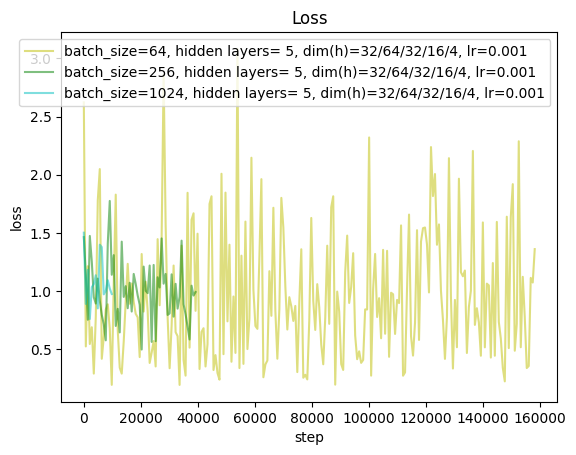

In [41]:
colors = ['r', 'y', 'g', 'c', 'b', 'm', 'w']

n = 700

for i in [1,2,3]:
    arr = []
    x = np.arange(0, len(data[i]['loss']), n, dtype=int)
    for j in range(len(data[i]['loss'])):
        if j%n==0:
            arr.append(data[i]['loss'][j])
    
    plt.plot(x, arr, colors[i], label='batch_size='+str(data[i]['batch_size'])+', hidden layers= 5, dim(h)=32/64/32/16/4, lr='+str(data[i]['lr']),  alpha=0.5)

plt.xlabel('step') 
plt.ylabel('loss') 
plt.title("Loss")
plt.legend()
plt.show()

### Validation Loss, Plot every 50 points

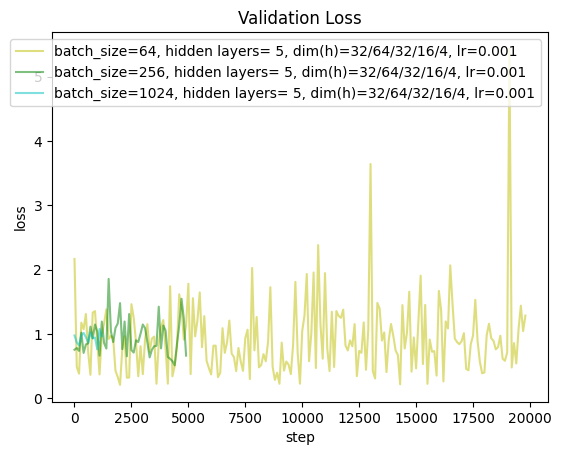

In [38]:
colors = ['r', 'y', 'g', 'c', 'b', 'm', 'w']

n = 100

for i in [1,2,3]:
    arr = []
    x = np.arange(0, len(data[i]['valid_loss']), n, dtype=int)
    for j in range(len(data[i]['valid_loss'])):
        if j%n==0:
            arr.append(data[i]['valid_loss'][j])
    
    plt.plot(x, arr, colors[i], label='batch_size='+str(data[i]['batch_size'])+', hidden layers= 5, dim(h)=32/64/32/16/4, lr='+str(data[i]['lr']),  alpha=0.5)

plt.xlabel('step') 
plt.ylabel('loss') 
plt.title("Validation Loss")
plt.legend()
plt.show()

### Test Loss before training

###### model.eval()

In [53]:
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
y_pred = model(X_test)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test Loss before training: ', before_train.item())

Test Loss before training:  1.031524419784546



## Training the Model
---

In [11]:
# Training the model with Validation
min_valid_loss = np.inf
loss_values = []
valid_loss_values = []
start = time.time()

for epoch in range(num_epochs):
    train_loss = 0.0
    for (x, y) in train_loader: # per batch
        x = x.to(dtype=torch.float32).to(device)
        y = y.to(dtype=torch.float32).to(device)
        
        # Forward pass
        outputs = model(x)
        # Find the loss
        loss = criterion(outputs, y)
        
        # Backward and optimize
        # Clear the gradients
        optimizer.zero_grad()
        # Calculate the gradients
        loss.backward()
        # Update weights
        optimizer.step()
        # Record the loss
        loss_values.append(loss.item())
        # Calculate Loss
        train_loss += loss.item()
    
    #validation step
    valid_loss = 0.0
    for (x, y) in valid_loader:
        x = x.to(dtype=torch.float32).to(device)
        y = y.to(dtype=torch.float32).to(device)
        
        # Forward pass
        outputs = model(x)
        # Find the loss
        loss = criterion(outputs, y)
        # Record the loss
        valid_loss_values.append(loss.item())
        # Calculate Loss
        valid_loss += loss.item()
        
    if (epoch+1) % 5 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss/ len(train_loader):.4f}, Validation Loss: {valid_loss/ len(valid_loader):.4f}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss/ len(valid_loader):.4f} ---> {valid_loss/ len(valid_loader):.4f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        data = {
        "model_state": model.state_dict(),
        "input_size": input_size,
        "hidden_size_1": hidden_size_1,
        "hidden_size_2": hidden_size_2,
        "output_size": output_size,
        }
        FILE = "model.pth"
        torch.save(data, FILE)

print("Total time: ", time.time() - start, "seconds")
print(f'final loss: {loss.item():.4f}')

/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2048])) that is different to the input size (torch.Size([2048, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([361])) that is different to the input size (torch.Size([361, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/liuxr/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([813])) that is different to the input size (torch.Size([813, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they ha

Validation Loss Decreased(inf ---> 1.1083) 	 Saving The Model
Validation Loss Decreased(1.1083 ---> 1.0405) 	 Saving The Model
Validation Loss Decreased(1.0405 ---> 1.0385) 	 Saving The Model
Validation Loss Decreased(1.0385 ---> 0.9899) 	 Saving The Model
Epoch [5/800], Training Loss: 1.0177, Validation Loss: 0.9693
Validation Loss Decreased(0.9899 ---> 0.9693) 	 Saving The Model
Validation Loss Decreased(0.9693 ---> 0.9566) 	 Saving The Model
Validation Loss Decreased(0.9566 ---> 0.9527) 	 Saving The Model
Validation Loss Decreased(0.9527 ---> 0.9466) 	 Saving The Model
Epoch [10/800], Training Loss: 0.9917, Validation Loss: 0.9598
Epoch [15/800], Training Loss: 0.9860, Validation Loss: 0.9541
Validation Loss Decreased(0.9466 ---> 0.9451) 	 Saving The Model
Validation Loss Decreased(0.9451 ---> 0.9312) 	 Saving The Model
Epoch [20/800], Training Loss: 0.9891, Validation Loss: 0.9379
Epoch [25/800], Training Loss: 0.9850, Validation Loss: 0.9412
Epoch [30/800], Training Loss: 0.9906, 

KeyboardInterrupt: 

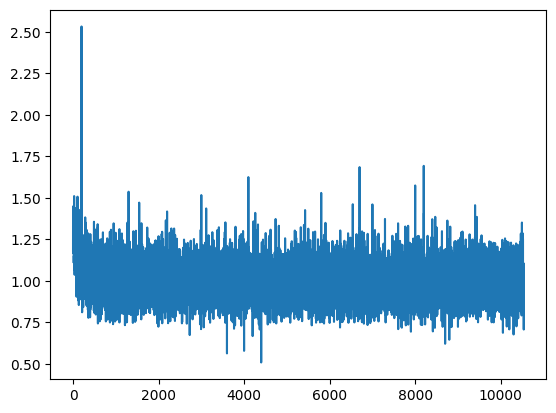

In [12]:
plt.plot(loss_values)

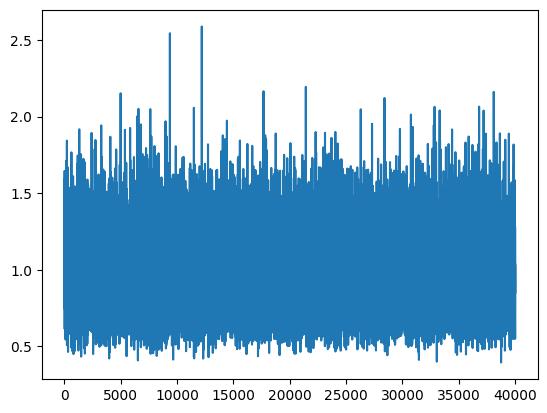

In [73]:
plt.plot(valid_loss_values)

### Saving the loss and validation loss

In [13]:
#np.savetxt('./data/loss_values_b16_e200_remove-999.txt',loss_values)
#np.savetxt('./data/valid_loss_values_b16_e200_remove-999.txt',valid_loss_values)
#np.savetxt('./data/loss_values_b32_e200.txt',loss_values)
#np.savetxt('./data/valid_loss_values_b32_e200.txt',valid_loss_values)
#np.savetxt('./data/loss_values_b64_e300_remove-999.txt',loss_values)
#np.savetxt('./data/valid_loss_values_b64_e300_remove-999.txt',valid_loss_values)
np.savetxt('./data/loss_values_b2048_e100_-999to-5_hidden32&8_remove_top_bottom_lr0.001.txt',loss_values)
np.savetxt('./data/valid_loss_values_b2048_e100_-999to-5_hidden32&8_remove_top_bottom_lr0.001.txt',valid_loss_values)

In [3]:
loss_values = np.loadtxt("./data/loss_values_b16_e200.txt")
valid_loss_values = np.loadtxt("./data/valid_loss_values_b16_e200.txt")

## More visualisation

In [3]:
loss_values_b16_e200 = np.loadtxt("./data/loss_values_b16_e200_remove-999.txt")
valid_loss_values_b16_e200 = np.loadtxt("./data/valid_loss_values_b16_e200_remove-999.txt")
loss_values_b32_e200 = np.loadtxt("./data/loss_values_b32_e200_remove-999.txt")
valid_loss_values_b32_e200 = np.loadtxt("./data/valid_loss_values_b32_e200_remove-999.txt")
loss_values_b64_e300 = np.loadtxt("./data/loss_values_b64_e300_remove-999.txt")
valid_loss_values_b64_e300 = np.loadtxt("./data/valid_loss_values_b64_e300_remove-999.txt")
#loss_values_b128_e400_1hidden8 = np.loadtxt("./data/loss_values_b128_e400_-999to-5_1hidden_8_remove_entireX-999.txt")
#valid_loss_values_b128_e400_1hidden8 = np.loadtxt("./data/valid_loss_values_b128_e400_-999to-5_1hidden_8_remove_entireX-999.txt")
loss_values_b128_e400_2hidden8 = np.loadtxt("./data/loss_values_b128_e400_-999to-5_2hidden_remove_entireX-999.txt")
valid_loss_values_b128_e400_2hidden8 = np.loadtxt("./data/valid_loss_values_b128_e400_-999to-5_2hidden_remove_entireX-999.txt")
loss_values_b128_e400_2hidden32N8 = np.loadtxt("./data/loss_values_b128_e400_-999to-5_hidden32&8_remove_entireX-999.txt")
valid_loss_values_b128_e400_2hidden32N8 = np.loadtxt("./data/valid_loss_values_b128_e400_-999to-5_hidden32&8_remove_entireX-999.txt")

loss_values_b256_e600 = np.loadtxt("./data/loss_values_b256_e600_-999to-5_hidden32&8_remove_entireX-999.txt")
valid_loss_values_b256_e600 = np.loadtxt("./data/valid_loss_values_b256_e600_-999to-5_hidden32&8_remove_entireX-999.txt")
loss_values_b512_e800 = np.loadtxt("./data/loss_values_b512_e800_-999to-5_hidden32&8_remove_entireX-999_lr0.001.txt")
valid_loss_values_b512_e800 = np.loadtxt("./data/valid_loss_values_b512_e800_-999to-5_hidden32&8_remove_entireX-999_lr0.001.txt")
loss_values_b512_e800_remove_top_bottom = np.loadtxt("./data/loss_values_b512_e800_-999to-5_hidden32&8_remove_top_bottom_lr0.001.txt")
valid_loss_values_b512_e800_remove_top_bottom = np.loadtxt("./data/valid_loss_values_b512_e800_-999to-5_hidden32&8_remove_top_bottom_lr0.001.txt")
loss_values_b1024_e800_remove_top_bottom = np.loadtxt("./data/loss_values_b1024_e800_-999to-5_hidden32&8_remove_top_bottom_lr0.001.txt")
valid_loss_values_b1024_e800_remove_top_bottom = np.loadtxt("./data/valid_loss_values_b1024_e800_-999to-5_hidden32&8_remove_top_bottom_lr0.001.txt")
loss_values_b2048_e100_remove_top_bottom = np.loadtxt("./data/loss_values_b2048_e100_-999to-5_hidden32&8_remove_top_bottom_lr0.001.txt")
valid_loss_values_b2048_e100_remove_top_bottom = np.loadtxt("./data/valid_loss_values_b2048_e100_-999to-5_hidden32&8_remove_top_bottom_lr0.001.txt")

#loss_values_b16_e200 = np.loadtxt("./data/loss_values_b16_e200_-999to-5_2hidden.txt")
#valid_loss_values_b16_e200 = np.loadtxt("./data/valid_loss_values_b16_e200_-999to-5_2hidden.txt")
#loss_values_b32_e200 = np.loadtxt("./data/loss_values_b32_e200_-999to-5_2hidden.txt")
#valid_loss_values_b32_e200 = np.loadtxt("./data/valid_loss_values_b32_e200_-999to-5_2hidden.txt")
#loss_values_b64_e300 = np.loadtxt("./data/loss_values_b64_e300_-999to-5_2hidden.txt")
#valid_loss_values_b64_e300 = np.loadtxt("./data/valid_loss_values_b64_e300_-999to-5_2hidden.txt")

In [ ]:
# transform a text file to pickle file 

# Hyper-parameters 
num_epochs = 800
batch_size = 512
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size_1 = 32
hidden_size_2 = 8
output_size = 1
print(input_size, output_size)

dict_a = {'epoch_num':400, 'batch_size':512, 'lr':0.001}
pickle.dump(dict_a, open('./pickle_data/loss_values_b512_e800_remove_top_bottom.pkl', 'wb'))

my_dict = pickle.load(open('./pickle_data/loss_values_b512_e800_remove_top_bottom.pkl', 'rb'))
my_dict

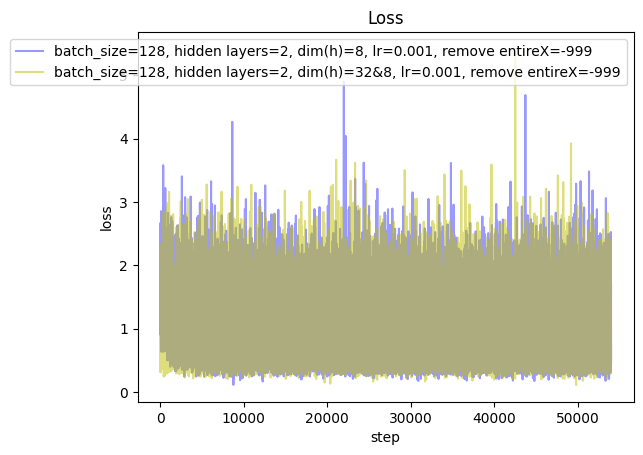

In [24]:
#plt.plot(loss_values_b16_e200, label='batch_size=16, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.5)
#plt.plot(loss_values_b32_e200,'y', label='batch_size=32, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.8)
#plt.plot(loss_values_b64_e300,'r', label='batch_size=64, hidden layers=1, dim(h)=16, lr=0.0001', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(loss_values_b128_e400_2hidden8,'b', label='batch_size=128, hidden layers=2, dim(h)=8, lr=0.001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.4)
plt.plot(loss_values_b128_e400_2hidden32N8,'y', label='batch_size=128, hidden layers=2, dim(h)=32&8, lr=0.001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.5)

plt.xlabel('step') 
plt.ylabel('loss') 
plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
#plt.plot(loss_values_b16_e200, label='batch_size=16, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.5)
#plt.plot(loss_values_b32_e200,'y', label='batch_size=32, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.8)
#plt.plot(loss_values_b64_e300,'r', label='batch_size=64, hidden layers=1, dim(h)=16, lr=0.0001', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(valid_loss_values_b128_e400_2hidden8,'b', label='batch_size=128, hidden layers=2, dim(h)=8, lr=0.001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.4)
plt.plot(valid_loss_values_b128_e400_2hidden32N8,'y', label='batch_size=128, hidden layers=2, dim(h)=32&8, lr=0.001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.5)

plt.xlabel('step') 
plt.ylabel('loss') 
plt.title("Validation Loss")
plt.legend()
plt.show()

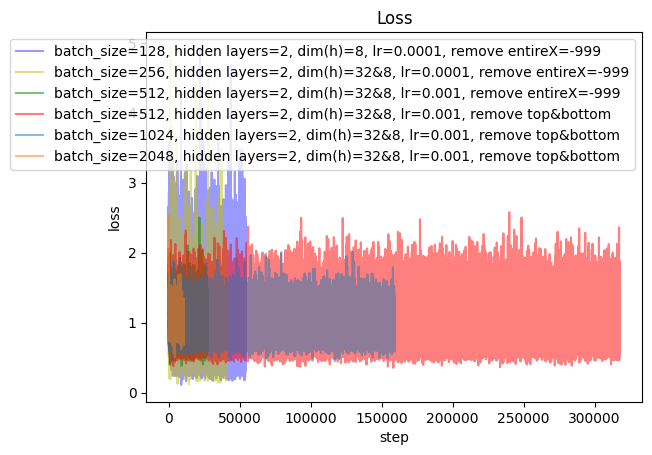

In [17]:
#plt.plot(loss_values_b16_e200, label='batch_size=16, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.5)
#plt.plot(loss_values_b32_e200,'y', label='batch_size=32, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.8)
#plt.plot(loss_values_b64_e300,'r', label='batch_size=64, hidden layers=1, dim(h)=16, lr=0.0001', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(loss_values_b128_e400,'b', label='batch_size=128, hidden layers=2, dim(h)=8, lr=0.0001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.4)
plt.plot(loss_values_b256_e600,'y', label='batch_size=256, hidden layers=2, dim(h)=32&8, lr=0.0001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(loss_values_b512_e800,'g', label='batch_size=512, hidden layers=2, dim(h)=32&8, lr=0.001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(loss_values_b512_e800_remove_top_bottom,'r', label='batch_size=512, hidden layers=2, dim(h)=32&8, lr=0.001, remove top&bottom', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(loss_values_b1024_e800_remove_top_bottom, label='batch_size=1024, hidden layers=2, dim(h)=32&8, lr=0.001, remove top&bottom', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(loss_values_b2048_e100_remove_top_bottom, label='batch_size=2048, hidden layers=2, dim(h)=32&8, lr=0.001, remove top&bottom', ls='-', ms=20, markevery=100, alpha=0.5)

plt.xlabel('step') 
plt.ylabel('loss') 
plt.title("Loss")
plt.legend()
plt.show()

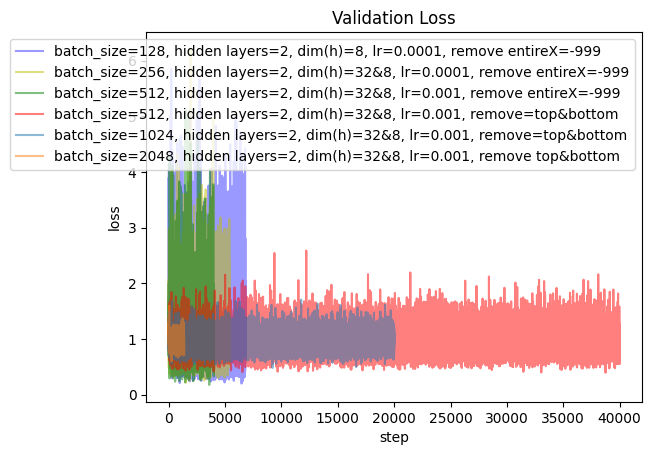

In [18]:
#plt.plot(valid_loss_values_b16_e200, label='batch_size=16, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.5)
#plt.plot(valid_loss_values_b32_e200,'y', label='batch_size=32, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.8)
#plt.plot(valid_loss_values_b64_e300,'r', label='batch_size=64, hidden layers=1, dim(h)=16', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(valid_loss_values_b128_e400,'b', label='batch_size=128, hidden layers=2, dim(h)=8, lr=0.0001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.4)
plt.plot(valid_loss_values_b256_e600,'y', label='batch_size=256, hidden layers=2, dim(h)=32&8, lr=0.0001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(valid_loss_values_b512_e800,'g', label='batch_size=512, hidden layers=2, dim(h)=32&8, lr=0.001, remove entireX=-999', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(valid_loss_values_b512_e800_remove_top_bottom,'r', label='batch_size=512, hidden layers=2, dim(h)=32&8, lr=0.001, remove=top&bottom', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(valid_loss_values_b1024_e800_remove_top_bottom, label='batch_size=1024, hidden layers=2, dim(h)=32&8, lr=0.001, remove=top&bottom', ls='-', ms=20, markevery=100, alpha=0.5)
plt.plot(valid_loss_values_b2048_e100_remove_top_bottom, label='batch_size=2048, hidden layers=2, dim(h)=32&8, lr=0.001, remove top&bottom', ls='-', ms=20, markevery=100, alpha=0.5)

plt.xlabel('step') 
plt.ylabel('loss') 
plt.title("Validation Loss")
plt.legend()
plt.show()

### Plot at a 50 interval

In [99]:
x = np.arange(0, len(valid_loss_values), 50, dtype=int)
x

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600,
       1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150,
       2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700,
       2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250,
       3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800,
       3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350,
       4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900,
       4950, 5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450,
       5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000,
       6050, 6100, 6150, 6200, 6250, 6300, 6350, 6400, 6450, 6500, 6550,
       6600, 6650, 6700, 6750])

In [100]:
#put x and y together 
n = 50
arr = []

for i in range(len(valid_loss_values)):
    if i%n==0:
        arr.append(valid_loss_values[i])

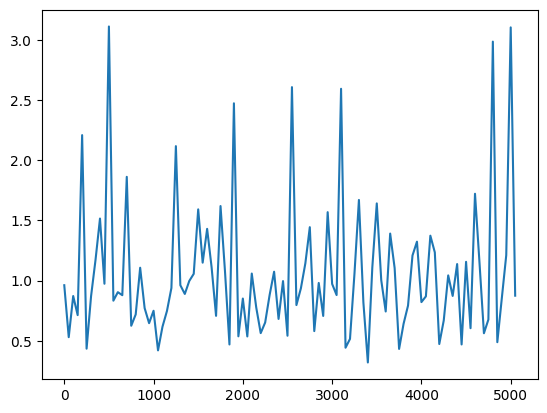

In [95]:
plt.plot(x, arr)


## Loading our Saved Model
---

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

FILE = "model.pth"
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size_1 = data["hidden_size_1"]
hidden_size_2 = data["hidden_size_2"]
output_size = data["output_size"]
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

NeuralNet(
  (l1): Linear(in_features=20, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


 
## Prediction with test dataset:
---

In [91]:
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
y_pred = model(X_test)
after_train = criterion(y_pred.squeeze(), y_test)
print('Test Loss after training: ', after_train.item())
print('Test Loss before training: ', before_train.item())

Test Loss after training:  1.0317400693893433
Test Loss before training:  1.5479086637496948


### investigation of the predicted data
the existance of -999 made the model lean towards the negative side.

In [97]:
y_pred_array = y_pred.detach().numpy()

In [98]:

df_describe = pd.DataFrame(y_pred_array)
df_describe.describe()

,0
count,2149.000000
mean,0.448416
std,0.028613
min,0.346357
25%,0.433717
50%,0.443437
75%,0.453586
max,0.701202


In [99]:
df_describe.min()

0    0.346357
dtype: float32

# Bibliography
---


**[1]** 	Wikipedia, "FeedForward Neural Network," Wikipedia, [Online]. Available: https://en.wikipedia.org/wiki/Feedforward_neural_network.

**[2]** 	T. Wood, "Activation Function," DeepAI, [Online]. Available: https://deepai.org/machine-learning-glossary-and-terms/activation-function.
